<h1> TP Séparation de sources </h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Génération de sources et d'un mélange

In [30]:
def generatesources(Nsources, Nsamples, choice):
    """ Generates sources with independent components (for ICA/BSS)

    Returned sources are normalized.

    Parameters
    ----------
    Nsources : int, number of sources
    Nsamples : int, number of samples
    choice : selected type of sources: 'bpsk', 'rand'

    Returns
    -------
    sources : ndarray Nsour x Nsamples
              realization of the sources
    """
    if choice == 'bpsk':
        sources = np.random.randint(0, 2, (Nsources, Nsamples)) *2 -1
    elif choice == 'rand':
        sources = np.random.rand(Nsources, Nsamples)

    # renormalize (unit variance)
    sources_unormalised = sources.copy()
    renormfactors= np.sqrt(np.var(sources, axis=1))
    sources = sources / renormfactors[:,np.newaxis]
    return sources

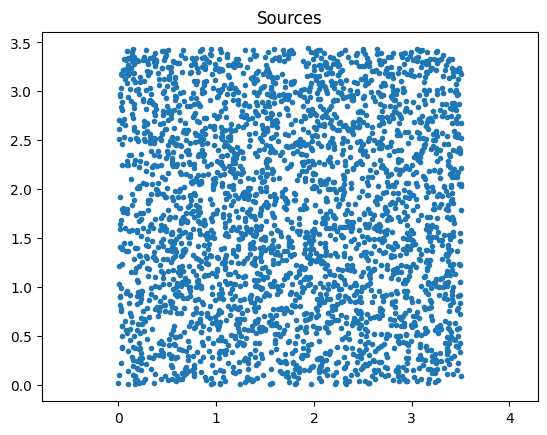

In [33]:
N, T = 2, 3000
S = generatesources(N, T, "rand")
fig, ax = plt.subplots()
ax.plot(S[0, :], S[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Sources")

In [43]:
def cum(X):
    """ Estimates 4th order cumulant 
    
    Parameters
    ----------
    X : array (N, T)
    
    Returns
    -------
    C : array (N, 1)
        Each component of C is an empirical estimate of corresponing row of X 
    """
    N, T = X.shape
    C = np.zeros(N)
    C = np.mean(X**4, axis=1) - 3*np.mean(X**2, axis=1)**2
    
    return C[:, np.newaxis] # pour avoir matrice NxT a partir vecteur taille N

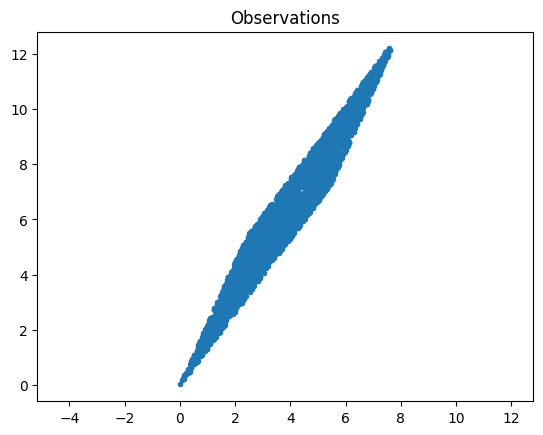

In [53]:
A = np.random.randn(N, N)
X = A@S
fig, ax = plt.subplots()
ax.plot(X[0, :], X[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Observations")

## Approche par blanchiment

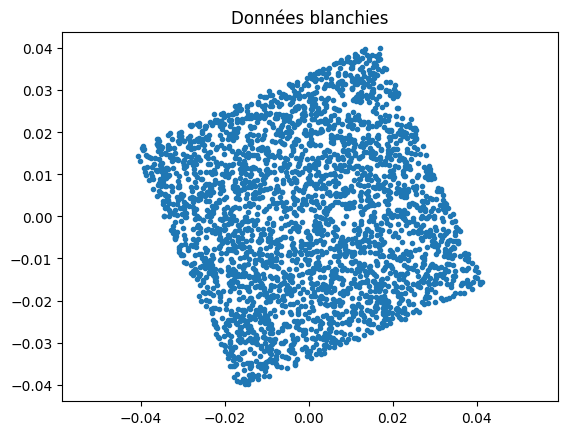

In [6]:
U, S, V = #A VOUS DE JOUER : calcul SVD
W = #A VOUS DE JOUER : matrice blanchiment
Z = #A VOUS DE JOUER : données blanchies
fig, ax = plt.subplots()
ax.plot(Z[0, :], Z[1, :], linestyle="", marker=".")
_ = ax.axis("equal")
_ = ax.set_title("Données blanchies")

In [7]:
def rotation(theta):
    """ Returns 2x2 rotation matrix with angle theta
    """
    M = #A VOUS DE JOUER
    return M

def contraste1(Y):
    """ Valeur du contraste C1 du TP """
    return #A VOUS DE JOUER

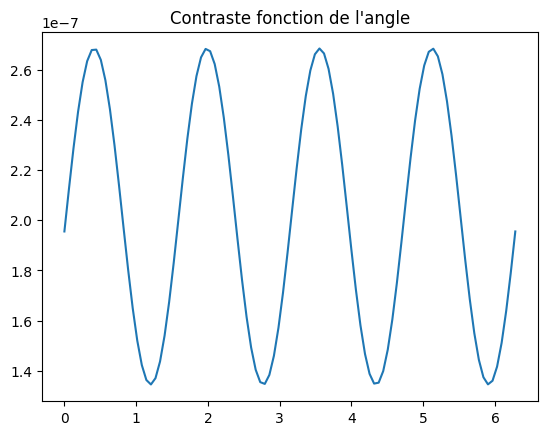

In [8]:
theta_valeurs = np.linspace(0, 2*np.pi, 100)
contraste1_valeurs = []
for theta in theta_valeurs:
    contraste1_valeurs.append(contraste1(rotation(theta)@Z))
fig, ax = plt.subplots()
_ = ax.plot(theta_valeurs, contraste1_valeurs)
_ = ax.set_title("Contraste fonction de l'angle")
    

## Approche par déflation

In [78]:
# fonctions pour evaluation du critère, gradient, facteur de renormalisation
def crit(b, X):
    """ Evaluates (Cum4{y}/E{y^2}^2)^2, where y=b.T x"""
    y=b.T@X
    C = cum(y)
    esp= np.mean(y**2,axis=1)**2

    return (C/esp)**2
    
def grad(b, X):
    """ Evaluates gradient of(Cum4{y}/E{y^2}^2)^2, where y=b.T x"""
    y=b.T@X
    Mfour= np.mean(y**4, axis=1)
    Mtwo= np.mean(y**2, axis=1)
    dMfour= np.mean(4*y**3*X, axis=1)
    dMtwo= np.mean(2*y*X, axis=1)
    dMfouroverMtwominusthree=dMfour/(Mtwo**2) -2*Mfour*dMtwo/Mtwo**3
    dz=2*(Mfour/(Mtwo**2)-3)*dMfouroverMtwominusthree

    return dz[:, np.newaxis]

def renorm(b, X):
    """ Evaluate renomalization factor sqrt(E{y^2}) where y=b.T x"""
    y=b.T@X
    return np.sqrt(np.mean(y**2,axis=1))

# gradient projeté
def projgrad(X, mu=1e-3):
    """ Projected gradient algorithm for maximizing crit"""
    MAXITER = 1000
    b = np.ones((N, 1))
    b = b/renorm(b, X)  # initialisation de b algo gradient
    crit_trace = [crit(b, X)]
    for i in range(MAXITER):
        b = b + mu*grad(b, X)
        b = b/renorm(b, X)
        crit_trace.append(crit(b, X))  # garder trace du critère pour vérifier algo
        
    return b, crit_trace

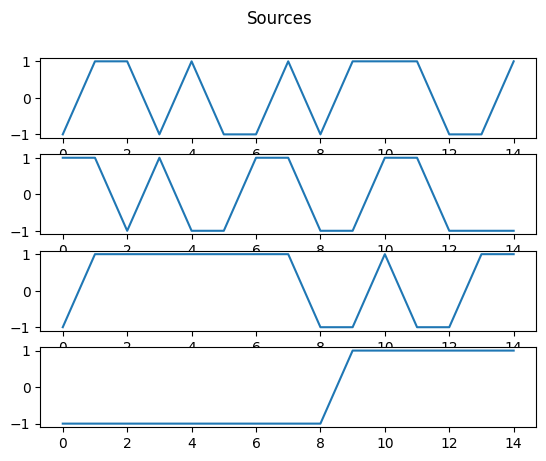

In [69]:
N, T = 4, 5000
S = generatesources(N, T, "bpsk")
fig, ax = plt.subplots(N, 1)
for i in range(N):
    ax[i].plot(S[i, 0:15])
_ = fig.suptitle("Sources")

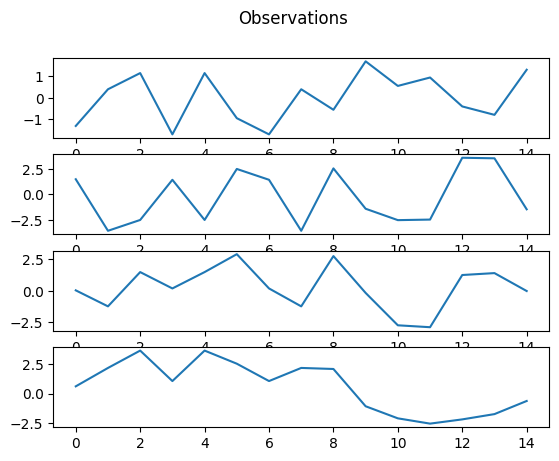

In [70]:
A = np.random.randn(N, N)
X = A@S
fig, ax = plt.subplots(N, 1)
for i in range(N):
    ax[i].plot(X[i, 0:15])
_ = fig.suptitle("Observations")

In [90]:
b, crit_trace = projgrad(X)
print(len(crit_trace))
b.shape

1001


(4, 1)

ValueError: x and y can be no greater than 2D, but have shapes (1001,) and (1001, 1, 1)

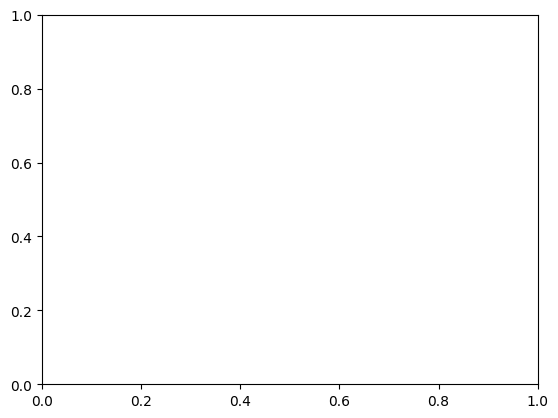

In [92]:
ax.plot() # cohérent: croissance critère, pas approximativement ok

In [83]:
b.T@A  # cohérent: unique +-1 sur la ligne

array([[-0.01160654, -0.99328907, -0.12052281, -0.02266068]])

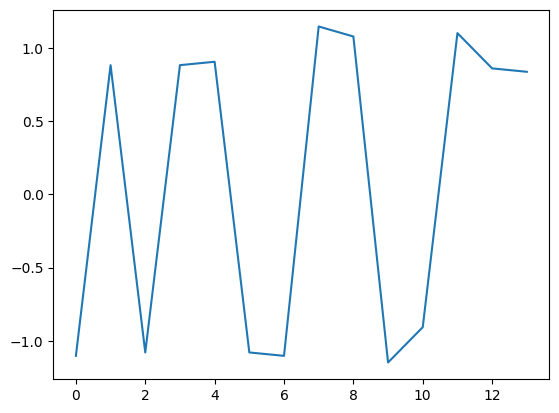

In [84]:
y = b.T@X
plt.plot(y[:, 1:15].T)  # reconstitution d'une source correcte